# Omid Roshani
### Email : omid.roshani@outlook.com

# 1. Import Packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from model import Model
import json
import codecs
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 2. Open Files & Preprocess Data

### 2.1 Open Files

In [2]:
data = pd.read_csv('data/data.csv')
data.set_index('Unnamed: 0')
del data['Unnamed: 0']
data['Start_time'] = pd.to_datetime(data['Start_time'])
data['End_time'] = pd.to_datetime(data['End_time'])
data['Date'] = pd.to_datetime(data['Date'])

test_data = pd.read_csv('data/test.csv')
test_data.set_index('Unnamed: 0')
del test_data['Unnamed: 0']
test_data['Start_time']= pd.to_datetime(test_data['Start_time'])
test_data['End_time']= pd.to_datetime(test_data['End_time'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [3]:
data.head(3)

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
0,Vidéoclips V,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,No,Yes,No,No,0.9,20.400
1,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:00:00,2016-08-29 08:30:00,2,Apollo dans l'frigo,NaN,Informal Education and Recreation and Leisure,No,Yes,No,No,0.5,19.125
2,Infopublicité,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:30:00,2016-08-29 09:00:00,2,Infopublicité,NaN,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,0.3,19.125


In [4]:
print("Data.csv has {} rows & {} Columns".format(data.shape[0],data.shape[1]))
print("Test.csv has {} rows & {} Columns".format(test_data.shape[0],test_data.shape[1]))

Data.csv has 616656 rows & 19 Columns
Test.csv has 154165 rows & 18 Columns


### 2.2 Missing Values Imputation

##### Data.csv :

In [5]:
null_cols = data.isnull().sum()
null_cols = null_cols[null_cols > 0]
print(null_cols)

Start_time                                    43
End_time                                      43
Name of episode                           222579
Temperature in Montreal during episode     83344
dtype: int64


##### Test.csv :

In [6]:
null_cols = test_data.isnull().sum()
null_cols = null_cols[null_cols > 0]
print(null_cols)

Start_time                                   22
End_time                                     22
Name of episode                           30619
Temperature in Montreal during episode    23229
dtype: int64


#### The number of "null" data in the 'Start_time' & 'End_time' columns is also very small, and deleting them does not affect the results so it is best to delete them

In [7]:
data      = data[ data['Start_time'].notna() ]
test_data = test_data[ test_data['Start_time'].notna() ]

#### The DateTimes in this data are in an order that does not help us much in modeling, and it is best to decompose these datetimes into smaller sections.

In [8]:
data['Month'] = data['Start_time'].dt.month
data['Hour']  = data['Start_time'].dt.hour
data['Day']   = data['Start_time'].dt.day

test_data['Month'] = test_data['Start_time'].dt.month
test_data['Hour']  = test_data['Start_time'].dt.hour
test_data['Day']   = test_data['Start_time'].dt.day

#### As we can see in the following sections, the Name of episode column has many empty rows so using imputation for this column will not be of much use so we will continue with deleting this column

In [9]:
del data['Name of episode']
del data['Start_time']
del data['End_time']
del data['Date']

del test_data['Name of episode']
del test_data['Start_time']
del test_data['End_time']
del test_data['Date']

#### It's better to move the 'Market Share_total' column to the end of the list of columns

In [10]:
cols = data.columns.tolist()
cols.insert(len(cols), cols.pop(cols.index('Market Share_total')))
data = data.reindex(columns = cols)

In [11]:
data.head()

,Episode,Station,Channel Type,Season,Year,Day of week,Length,Name of show,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,Month,Hour,Day,Market Share_total
0,Vidéoclips V,V Total,General Channel,Fall,2016,Monday,8,Vidéoclips V,Music Video Clips,No,Yes,No,No,20.400,8,6,29,0.9
1,Apollo dans l'frigo,V Total,General Channel,Fall,2016,Monday,2,Apollo dans l'frigo,Informal Education and Recreation and Leisure,No,Yes,No,No,19.125,8,8,29,0.5
2,Infopublicité,V Total,General Channel,Fall,2016,Monday,2,Infopublicité,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,19.125,8,8,29,0.3
3,"Infos, Les",V Total,General Channel,Fall,2016,Monday,4,"Infos, Les",News,No,Yes,No,No,18.125,8,9,29,1.7
4,"Souper presque parfait, Un",V Total,General Channel,Fall,2016,Monday,2,"Souper presque parfait, Un",Reality Programs,No,Yes,No,No,18.250,8,10,29,2.2


### 2.3 Interpolation

#### By interpolation we fill some of the dataframe cells that are Null

In [12]:
data.interpolate(inplace = True)
data.dropna(inplace = True)

test_data.interpolate(inplace = True)
test_data.dropna(inplace = True)

In [13]:
print("Data.csv has {} rows & {} Columns".format(data.shape[0],data.shape[1]))
print("Test.csv has {} rows & {} Columns".format(test_data.shape[0],test_data.shape[1]))

Data.csv has 616613 rows & 18 Columns
Test.csv has 154143 rows & 17 Columns


# 3. Feature Selection

#### In this section, we use catboost to determine the importance of columns so we can remove less important columns if needed.

In [14]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

X=data.drop(columns=['Market Share_total'])

print(X.columns)

Index(['Episode', 'Station', 'Channel Type', 'Season', 'Year', 'Day of week',
       'Length', 'Name of show', 'Genre', 'First time or rerun',
       '# of episode in the season', 'Movie?',
       'Game of the Canadiens during episode?',
       'Temperature in Montreal during episode', 'Month', 'Hour', 'Day'],
      dtype='object')


In [15]:
categorical_features_indices =[0,1,2,3,5,7,8,9,10,11,12]

y=data['Market Share_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=52)

In [16]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model

In [17]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

RMSE on training data: 0.8744080352769563
RMSE on test data: 0.8612881541946842


In [18]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

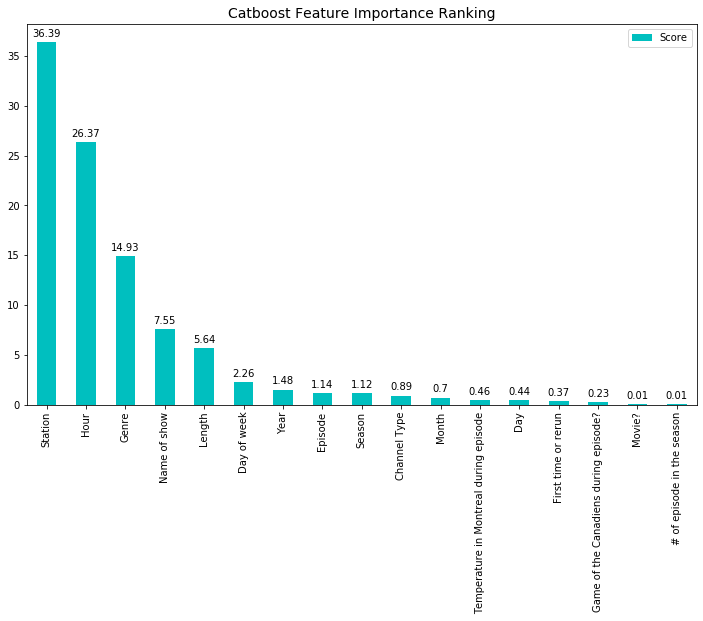

In [19]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

# 4. Labeling :

### 4.1 Labeling Categorical Columns :

#### We have a lot of categorical columns in this data which is not correct to delete so we try to get the most out of the features by labeling

In [20]:
object_cols = [col for col in data.columns if data[col].dtype == "object"]

In [21]:
labeled_data      = data.copy()
labeled_test_data = test_data.copy()

In [22]:
encoders = {}
encoders.clear()

for col in object_cols:
    le = LabelEncoder()
    labeled_data[col] = le.fit_transform(labeled_data[col])
    le.classes_ = np.append(le.classes_, '<unknown>')
    
    labeled_test_data[col] = labeled_test_data[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    labeled_test_data[col] = le.transform(labeled_test_data[col])
    
    encoders[col] = le

In [23]:
cols = labeled_data.columns.tolist()

### 4.2 Visualization

#### Using the heatmap we can easily see the correlation of features

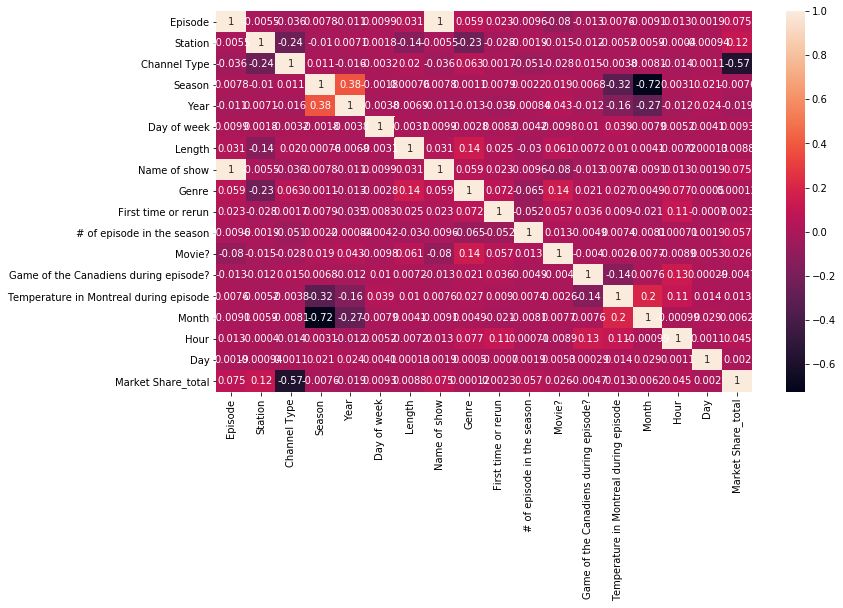

In [24]:
Var_Corr = labeled_data.corr()
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [25]:
scaler = MinMaxScaler()
labeled_data_scaled = scaler.fit_transform(labeled_data)
labeled_data_scaled = pd.DataFrame(labeled_data_scaled,columns = cols)
labeled_data_scaled['Market Share_total'] = labeled_data['Market Share_total']

In [26]:
labeled_data_scaled.head()

,Episode,Station,Channel Type,Season,Year,Day of week,Length,Name of show,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,Month,Hour,Day,Market Share_total
0,0.955429,0.913043,0.0,0.0,0.0,0.166667,0.086957,0.955429,0.423077,0.0,1.0,0.0,0.0,0.766733,0.636364,0.260870,0.933333,0.9
1,0.037242,0.913043,0.0,0.0,0.0,0.166667,0.021739,0.037242,0.307692,0.0,1.0,0.0,0.0,0.746293,0.636364,0.347826,0.933333,0.5
2,0.311995,0.913043,0.0,0.0,0.0,0.166667,0.021739,0.311995,0.269231,0.0,1.0,0.0,0.0,0.746293,0.636364,0.347826,0.933333,0.3
3,0.312294,0.913043,0.0,0.0,0.0,0.166667,0.043478,0.312294,0.538462,0.0,1.0,0.0,0.0,0.730261,0.636364,0.391304,0.933333,1.7
4,0.877954,0.913043,0.0,0.0,0.0,0.166667,0.021739,0.877954,0.769231,0.0,1.0,0.0,0.0,0.732265,0.636364,0.434783,0.933333,2.2


#### After scaling the data we can see thث distribution of each feature

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

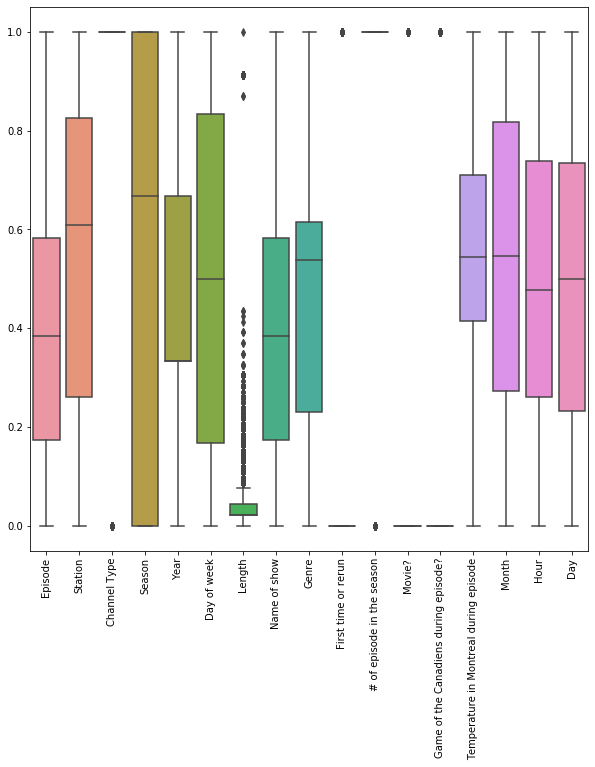

In [27]:
plt.figure(figsize=(10,10))
sns.boxplot(data=labeled_data_scaled[labeled_data_scaled.columns[:-1]])
plt.xticks(rotation=90)

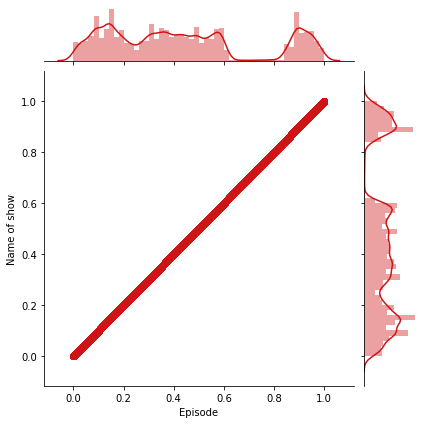

In [28]:
x_features = labeled_data_scaled[labeled_data_scaled.columns[:-1]]
sns.jointplot(x_features.loc[:,'Episode'], x_features.loc[:,'Name of show'], kind="regg", color="#ce1414")

# 5. Model :

### 5.1 Import most usefull Regressors

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor,ARDRegression,RANSACRegressor,PassiveAggressiveRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 5.2 Create Results dataframe to save models results & implement model function

In [30]:
res_cols=['Model', 'R2 Score' , 'MAE']
results = pd.DataFrame(columns=res_cols)

In [31]:
def run_model(estimator, data):
    model_name = type(estimator).__name__
    model = Model(estimator)
    model.fit(data)
    model.save_results("results/" + model_name + "_result.json")
    with codecs.open("results/" + model_name + "_result.json","r",encoding="utf-8") as j:
        result = json.load(j)
    #print(result['Cross-validation']['R2 Squared'])
    #print(result['Cross-validation']['MAE'])
    return model.estimator, pd.DataFrame([[model_name, result['Dev-Set']['R2 Squared'] , result['Dev-Set']['MAE'] ]],columns = res_cols)

### 5.3 Create and test different models and display the performance of each

In [32]:
model_lin, res = run_model(LinearRegression(), labeled_data)
results = results.append(res)

results saved to results/LinearRegression_result.json


In [33]:
model_rfr, res = run_model(RandomForestRegressor(n_estimators=10), labeled_data)
results = results.append(res)

results saved to results/RandomForestRegressor_result.json


In [34]:
model_ada, res = run_model(AdaBoostRegressor( DecisionTreeRegressor(max_depth=100)), labeled_data)
results = results.append(res)

results saved to results/AdaBoostRegressor_result.json


In [35]:
ransac = RANSACRegressor(loss='absolute_loss', max_trials=500, random_state=0)
model_ran, res = run_model(ransac, labeled_data)
results = results.append(res)

results saved to results/RANSACRegressor_result.json


In [36]:
model_knn, res = run_model(KNeighborsRegressor(), labeled_data)
results = results.append(res)

results saved to results/KNeighborsRegressor_result.json


In [37]:
model_dtr, res = run_model(DecisionTreeRegressor(), labeled_data)
results = results.append(res)

results saved to results/DecisionTreeRegressor_result.json


In [38]:
results

,Model,R2 Score,MAE
0,LinearRegression,0.33509937521776656,2.3690018568833273
0,RandomForestRegressor,0.8911125979511739,0.9567770835774947
0,AdaBoostRegressor,0.8965968751693933,0.9133614977240982
0,RANSACRegressor,0.17168565637166233,2.3095176320542383
0,KNeighborsRegressor,0.8048071297852041,1.2489448817195001
0,DecisionTreeRegressor,0.8202801525599199,1.1881640213928415


<BarContainer object of 6 artists>

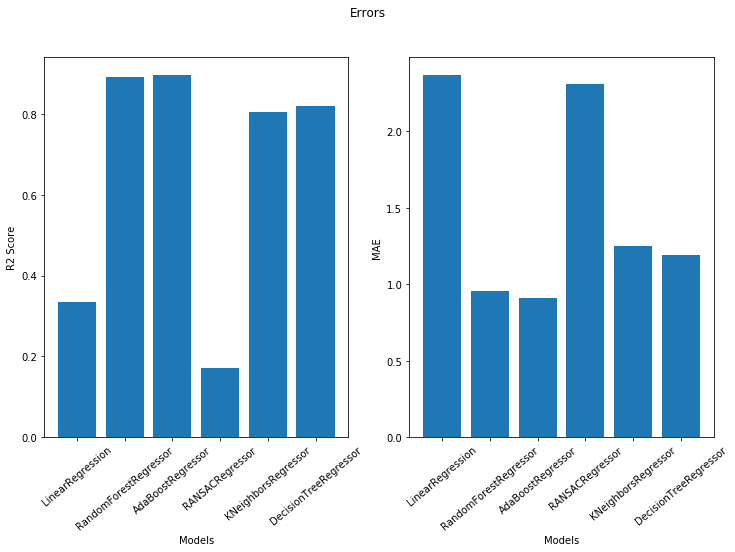

In [39]:
objects = results['Model'].values
y_pos = np.arange(len(objects))
performance1 = results['R2 Score'].astype(float).values
performance2 = results['MAE'].astype(float).values

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Errors')

ax1.set_ylabel('R2 Score')
ax1.set_xlabel('Models')
ax1.set_xticklabels(objects,rotation=40)
ax1.bar(objects, performance1)

ax2.set_ylabel('MAE')
ax2.set_xlabel('Models')
ax2.set_xticklabels(objects,rotation=40)
ax2.bar(objects, performance2)

### 5.4 Prediction

#### As we have seen, "RandomForestRegressor" had lower average MAE and R2 than other models, so we use this one for our predictions

In [40]:
predictions = model_ada.predict(labeled_test_data)

In [41]:
preds_data = test_data
preds_data['Market Share_total'] = predictions

In [43]:
preds_data.head()

,Episode,Station,Channel Type,Season,Year,Day of week,Length,Name of show,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,Month,Hour,Day,Market Share_total
0,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,Tuesday,2,Mom V.F. (M),Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-22.525,1,11,22,0.8
1,2 filles fauchées,VRAK+,Specialty Channel,Winter,2019,Tuesday,2,2 filles fauchées,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625,1,12,22,0.6
2,The Big Bang Theory,VRAK+,Specialty Channel,Winter,2019,Tuesday,2,The Big Bang Theory,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625,1,12,22,0.6
3,Flashpoint,VRAK+,Specialty Channel,Winter,2019,Tuesday,4,Flashpoint,Ongoing Dramatic Series,Yes,Yes,No,No,-20.375,1,13,22,0.9
4,Les Frères Scott,VRAK+,Specialty Channel,Winter,2019,Tuesday,4,Les Frères Scott,Ongoing Dramatic Series,No,Yes,No,No,-19.100,1,14,22,2.8


In [44]:
preds_data.to_csv('predictions.csv')